In [37]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]

In [38]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        torch.manual_seed(0)

      
        self.c1 = nn.Conv1d(1, 10, 10)
        #self.c2 = nn.Conv1d(1)
        self.a1 = nn.ReLU()
        self.l1 = nn.Linear(140,24)
        
    def forward(self, x):
        
        pred = self.c1(x)
        pred = self.a1(pred)
        pred = self.l1(pred)
        
        return pred

In [39]:
c = CustomCNN()
c

CustomCNN (
  (c1): Conv1d(1, 10, kernel_size=(10,), stride=(1,))
  (a1): ReLU ()
  (l1): Linear (140 -> 24)
)

In [40]:
appliance="hvac"
cell_type = "GRU"
num_hidden = 120
num_iterations = 300
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 0.1
p = 0.5
num_folds = 5
fold_num = 0

torch.manual_seed(0)

train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

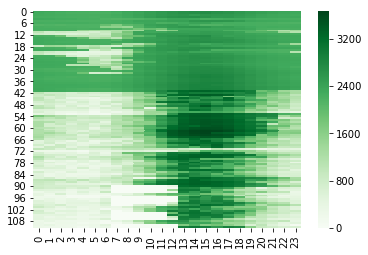

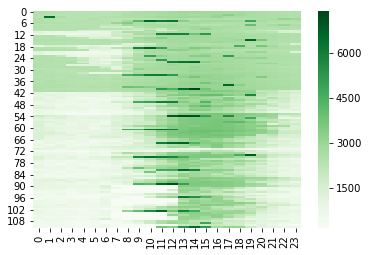

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.heatmap(train_appliance[5], cmap='Greens')
plt.figure()
sns.heatmap(train_aggregate[5],cmap='Greens')

In [41]:
train_appliance = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(-1, 24, 1)

In [43]:
train_aggregate.shape

(6048, 24, 1)

In [13]:
loss_func = nn.L1Loss()
c = CustomCNN()
if cuda_av:
    c = c.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(c.parameters(), lr=lr)

In [15]:
inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1,1))).type(torch.FloatTensor),
               requires_grad=True)
for t in range(num_iterations):
    out = Variable(torch.Tensor(train_appliance), requires_grad=True)
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()

    
    pred = c(inp)

    optimizer.zero_grad()
    

    
    loss = loss_func(pred, train_appliance)
    if t % 1 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

RuntimeError: Given input size: (1 x 1 x 1). Calculated output size: (10 x 1 x -8). Output size is too small at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/THNN/generic/SpatialConvolutionMM.c:45

In [ ]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)


print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})